### Initialize data and import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import io
import requests
import math
import statistics

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


from scipy import optimize
from datetime import timedelta, date, datetime

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.svm import SVR

plt.style.use('seaborn-whitegrid')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# Changed by Silvio: not being used
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Changed by Silvio: use Sesai data
#confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
confirmed_url = "https://painelcovid19.socioambiental.org/data/covid19/indigenas/sesai/compiled/timeseries/confirmed/timeseries.csv"
#deaths_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
deaths_url = "https://painelcovid19.socioambiental.org/data/covid19/indigenas/sesai/compiled/timeseries/deaths/timeseries.csv"
#recovered_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"

url = confirmed_url
s = requests.get(url).content
cases = pd.read_csv(io.StringIO(s.decode('utf-8')))

url = deaths_url
s = requests.get(url).content
deaths = pd.read_csv(io.StringIO(s.decode('utf-8')))

#url = recovered_url
#s = requests.get(url).content
#recovered = pd.read_csv(io.StringIO(s.decode('utf-8'))).iloc[:,0:65]

# Changed by Silvio: not being used
#cases['Country/Region'] = cases['Country/Region'].replace('Iran (Islamic Republic of)', 'Iran')
#cases['Country/Region'] = cases['Country/Region'].replace('Taiwan*', 'Taiwan')
#cases['Country/Region'] = cases['Country/Region'].replace('Criuse Ship', 'Diamond Princess')
#cases['Country/Region'] = cases['Country/Region'].replace('Korea, South', 'South Korea')

# Changed by Silvio: not being used
#deaths['Country/Region'] = deaths['Country/Region'].replace('Iran (Islamic Republic of)', 'Iran')
#deaths['Country/Region'] = deaths['Country/Region'].replace('Taiwan*', 'Taiwan')
#deaths['Country/Region'] = deaths['Country/Region'].replace('Criuse Ship', 'Diamond Princess')
#deaths['Country/Region'] = deaths['Country/Region'].replace('Korea, South', 'South Korea')

#recovered['Country/Region'] = recovered['Country/Region'].replace('Iran (Islamic Republic of)', 'Iran')
#recovered['Country/Region'] = recovered['Country/Region'].replace('Taiwan*', 'Taiwan')
#recovered['Country/Region'] = recovered['Country/Region'].replace('Criuse Ship', 'Diamond Princess')
#recovered['Country/Region'] = recovered['Country/Region'].replace('Korea, South', 'South Korea')

countries = cases.iloc[:,1].unique()
countries.sort()

# Changed by Silvio: use Sesai data
#demo = pd.read_csv("server/data/world_demographics.csv")
demo = pd.read_csv("server/data/sesai_demographics.csv")

# Changed by Silvio: not being used
#demo["Country or Area"] = demo["Country or Area"].replace("Viet Nam", "Vietnam")
#demo["Country or Area"] = demo["Country or Area"].replace("United States of America", "US")
#demo["Country or Area"] = demo["Country or Area"].replace("United Kingdom of Great Britain and Northern Ireland", "United Kingdom")
#demo["Country or Area"] = demo["Country or Area"].replace("Republic of Korea", "South Korea")
#demo["Country or Area"] = demo["Country or Area"].replace("Venezuela (Bolivarian Republic of)", "Venezuela")
#demo["Country or Area"] = demo["Country or Area"].replace('Iran (Islamic Republic of)', 'Iran')

# Changed by Silvio: not being used
#duc = demo["Country or Area"].unique()
#duc.sort()

deathrate_age = list(range(0,120))
deathrate_age[0:30] = [0]*30
deathrate_age[30:40] = [0.0012]*10
deathrate_age[40:50] = [0.0009]*10
deathrate_age[50:60] = [0.0039]*10
deathrate_age[60:70] = [0.0142]*10
deathrate_age[70:80] = [0.0474]*10
deathrate_age[80:120] = [0.083]*40

print("Latest date: ", cases.columns.values[-1])

Latest date:  5/17/20


Calculate Vulnerability

In [2]:
def calcVF(country1, country2):
    ma = np.where(demo["Country or Area"] == country1)[0]
    demo_c1 = demo.iloc[ma,:]
    ma = np.where(demo["Country or Area"] == country2)[0]
    demo_c2 = demo.iloc[ma,:]
    ll = list(range(0,120))
    ll = [str(i) for i in ll]
    ma = np.where(np.isin(demo_c1["Age"], np.array(ll)))[0]
    demo_c1 = demo_c1.iloc[ma,:]
    ma = np.where(np.isin(demo_c2["Age"], np.array(ll)))[0]
    demo_c2 = demo_c2.iloc[ma,:]
    vulnerable_c1 = [a * b for a, b in zip(demo_c1["Value"], deathrate_age)]
    vulnerable_c2 = [a * b for a, b in zip(demo_c2["Value"], deathrate_age)]
    v_c1 = sum(vulnerable_c1)/sum(demo_c1["Value"])
    v_c2 = sum(vulnerable_c2)/sum(demo_c2["Value"])
    exp_diff = v_c1/v_c2
    return(exp_diff)

Calculate Growth Rate

In [3]:
def calculateGR(country1, d_shift):
    ma = np.where(cases["Country/Region"] == country1)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c1 = d_count_1 / c_count_1
    
    # Changed by Silvio: Sesai has a smaller dataset
    #d_cases = np.where(d_count_1 > 10)[0]
    d_cases = np.where(d_count_1 > 0)[0]
    
    # Changed by Silvio: Debug
    #print('Debug: ' + country1)
    #print(ma)
    #print(c_count_1)
    #print(d_count_1)
    #print(d_cases)
    
    sds2 = d_count_1[d_cases]
    s1 = list(sds2)+[0]
    s2 = [0]+list(sds2)
    gr = np.array(s1)/np.array(s2)
    gr = pd.Series(np.array(gr[1:(len(gr)-1)]))

    # Changed by Silvio: Debug
    #print(gr)
    #print(list(gr))
    #print(len(list(gr)))
        
    new_deaths = np.array(s1)-np.array(s2)
    
    mean_gr = sum(list(gr))/len(list(gr))
    
    # Changed by Silvio: Debug
    #print(mean_gr)
    #print(math.log(mean_gr))
    
    # Changed by Silvio: not being used
    #mean_double = math.log(2)/math.log(mean_gr)
    
    gr.index = d_count_1[d_cases][1:len(d_cases)].index
    doublings = np.log(2)/np.log(gr)

    tran = [(datetime.strptime(i, "%m/%d/%y") - timedelta(days=d_shift)).strftime("%-m/%-d/%y") for i in gr.index]
    gr.index = tran
    return(gr)

Plot Growth Rate

In [4]:
def plotGR(country1, gr, doublings):
    
    popt, params_covariance = optimize.curve_fit(funcLin, range(0,4), gr[-4:], p0=[2, 2])
    linf = funcLin(np.array(range(0,4)), *popt)

    
    plt.figure(figsize=(10,6))
    fig, ax = plt.subplots(constrained_layout=True)
    ax.grid(False)

    plt.ylim(0.95, 1.8)
    res1, = plt.plot(gr, 'ro-', label="Growth Rate ("+country1+")")
    plt.ylabel("growth rate")

    resx, = plt.plot(range(len(gr)-len(linf),len(gr)), linf, 'go-', label="Predicted Rate ("+country1+")")
    
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='y', colors='red')

    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    plt.xticks(rotation=60)
    ax2 = ax.twinx()
    ax2.yaxis.label.set_color('blue')
    ax2.tick_params(axis='y', colors='blue')

    res2, = ax2.plot(doublings, 'b^-', label="Doubling Time (days)")
    plt.ylim(top=8)
    plt.ylabel("doubling time (days)")
    plt.legend(handles=[res1, res2])
    plt.show()

PredictCases

In [5]:
def predictCases(country1, country2, d_shift, p=False):
    ma = np.where(cases["Country/Region"] == country1)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c1 = d_count_1 / c_count_1
    d_cases = np.where(d_count_1 > 10)[0]
    sds2 = d_count_1[d_cases]
    
    ma = np.where(cases["Country/Region"] == country2)[0]
    c_count_2 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_2 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c2 = d_count_2 / c_count_2

    predicted_deaths = list(range(0,d_shift+1))
    predicted_deaths[0] = sds2[-1]

    for i in range(1,d_shift+1):
        predicted_deaths[i] = predicted_deaths[i-1]*gr[-1]

    combined_deaths = list(sds2) + list(predicted_deaths[1:len(predicted_deaths)])
    predicted_cases = np.array(combined_deaths) / (exp_diff*dr_c2[-1])
    shift_cases = predicted_cases[-(len(d_cases)+1):-1]
    
    if p:
        plt.figure(figsize=(10,6))
        fig, ax = plt.subplots(constrained_layout=True)
        ax.grid(False)

        res1, = plt.plot(c_count_1[d_cases], 'bo-', label="Reported Cases ("+country1+")")
        res2, = plt.plot(shift_cases, 'ro-', label="Adjusted Cases ("+country1+")")
        plt.xticks(rotation=60)
        ax.axvline(x=len(d_cases)-6)

        plt.ylabel("cases")
        plt.xticks(rotation=90)
        plt.legend(handles=[res1, res2])
        plt.show()

    return(shift_cases)

Plot death rate

In [6]:
def plotDR(country1, country2):
    ma = np.where(cases["Country/Region"] == country1)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c1 = d_count_1 / c_count_1

    ma = np.where(cases["Country/Region"] == country2)[0]
    c_count_2 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_2 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c2 = d_count_2 / c_count_2

    sig_cases = np.where(c_count_1 > 100)[0]
    ax1 = plt.subplot(1,1,1)
    res1, = plt.plot(range(0,len(sig_cases)), c_count_1[sig_cases], 'ro-', linewidth=3, label="reported cases")

    ax1.grid(False)
    plt.xticks(rotation=60)
    ax2 = ax1.twinx()
    res3, = ax2.plot(d_count_1[sig_cases], 'gs-', linewidth=3, label="deaths")

    for label in ax1.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    plt.title(country1)
    ax1.set_ylabel('cases', color="black")
    color = 'green'
    ax2.set_ylabel('deaths', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.legend(handles=[res1, res3])

    plt.figure(figsize=(10,6))
    plt.rc('ytick', labelsize=23) 
    plt.rc('xtick', labelsize=13)

    res1, = plt.plot(dr_c1[sig_cases]*100, 'b.-', label="Death rate ("+country1+")")
    res2, = plt.plot(dr_c2[sig_cases]*100, 'r.-', label="Death rate ("+country2+")")
    plt.xticks(rotation=60)
    plt.ylabel("death rate")

    plt.legend(handles=[res1, res2])
    plt.show()


In [7]:
def getMGR(country, shift):
    gr = calculateGR(country, shift)
    mgr = mean_gr = sum(list(gr))/len(list(gr))
    return(mgr)

In [8]:
def extrapolateDeaths(country, fitrate, intervention, timescale=50, shift=0, pastDays=23):
    
    ma = np.where(cases["Country/Region"] == country)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c1 = d_count_1 / c_count_1
    d_cases = np.where(d_count_1 > 10)[0]
    sds2 = d_count_1[d_cases]
    
    gr = calculateGR(country, 23)
    predicted_deaths = list(range(0,timescale))
    predicted_deaths[0] = sds2[-(1+shift)]
    
    for i in range(1,timescale):
        if i < 23-pastDays:
            predicted_deaths[i] = predicted_deaths[i-1]*statistics.median(gr[-7:])
        else:
            predicted_deaths[i] = predicted_deaths[i-1]*fitrate[i+14-pastDays]
    
    dd =sds2.index
    datelist = pd.date_range(pd.to_datetime(dd[len(dd)-1], format='%m/%d/%y', errors='ignore'), periods=timescale).tolist()
    str_date = [d.strftime('%m/%d/%y') for d in datelist]
    
    return(pd.DataFrame(data=predicted_deaths, index=str_date))

In [9]:
def getallMGR():
    countries = cases.iloc[:,1].unique()
    countries.sort()

    gr_list = list()
    country_name = list()

    for country in countries:
        ma = np.where(cases['Country/Region'] == country)[0]
        d_count = deaths.iloc[ma, 4:].sum(axis=0)

        if np.max(d_count) > 50:
            mgr = getMGR(country, d_shift)
            gr_list.append(mgr)
            country_name.append(country)

    df = pd.DataFrame(data=gr_list, index=country_name)
    return(df)

In [25]:
def findDecayShift(growthrates, decay_spline):
    decay_shift = 0
    ff = fitLinear(growthrates[-4:])
    ff = statistics.median(growthrates[-5:])
    # Changed by Silvio: debug
    print(growthrates)
    print(decay_spline)
    while float(ff) < float(list(decay_spline)[decay_shift]):
        decay_shift = decay_shift +1
        if decay_shift-1 > len(decay_spline):
            break
    return(decay_shift)

In [11]:
 def funcLin(x, a, b):
        return((a * x) + b)

In [12]:
def fitLinear(x):
    popt, params_covariance = optimize.curve_fit(funcLin, range(0,4), x[-4:], p0=[2, 2])
    return(funcLin(np.array(range(3,4)), *popt))

In [13]:
def printStat(country1):
    print(country1)
    
    # Changed by Silvio: use BRASIL as the reference, but consider put South Korea back
    #country2 = "South Korea"
    country2 = "BRASIL"

    ma = np.where(cases["Country/Region"] == country1)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)

    print("Current Confirmed Cases:", c_count_1[-1])
    print("Current Confirmed Deaths:", d_count_1[-1])
    ggr = calculateGR(country1, 0)

    ma = np.where(cases["Country/Region"] == country1)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
    cde = d_count_1[-1]
    print(c_count_1[-6:])

    print("Current Confirmed Cases:", c_count_1[-1])
    print("Current Confirmed Deaths:", d_count_1[-1])

    ma = np.where(cases["Country/Region"] == country2)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)

    drr = d_count_1[-1]/c_count_1[-1]

    mean_days_death = 18
    asym_days = 5

    d_shift = mean_days_death + asym_days

    exp_diff = calcVF(country1, country2)
    print("Vunerablility Factor: ", str(round(exp_diff, 4)))

    exp_d = extrapolateDeaths(country1, fit_rate, -findDecayShift(ggr, fit_rate), timescale=80, pastDays=70)

    print("Total Deaths: ", str(int(exp_d.iloc[-1,0])))

    num = exp_d.iloc[d_shift]/(exp_diff*drr)
    print("Current Predicted Cases: ", str(int(num)))

    num = exp_d.iloc[-1]/(exp_diff*drr)
    print("Total Predicted Cases: ", str(int(num)))

    gr = calculateGR(country1, d_shift)
    print("Growth Rate: ", str(round(gr[-1], 5)))

    mean_gr = sum(list(gr))/len(list(gr))
    mean_double = math.log(2)/math.log(mean_gr)
    doublings = np.log(2)/np.log(gr)
    print("Days per Doubling: ", str(round(doublings[-1], 5)))

    print("------------------------------------")

In [14]:
def plotCaseCountry(country, ax1):
    ma = np.where(cases['Country/Region'] == country)[0]
    c_count = cases.iloc[ma, 4:].sum(axis=0)
    d_count = deaths.iloc[ma, 4:].sum(axis=0)
    
    sig_cases = np.where(c_count > 30)[0]
    
    res1, = plt.plot(c_count[sig_cases], 'ro-', linewidth=3, label="reported cases")
    plt.xticks(rotation=90)
    ax2 = ax1.twinx()
    res3, = ax2.plot(d_count[sig_cases], 'gs-', linewidth=3, label="deaths")

    plt.title(country)
    ax1.set_ylabel('cases', color="black")
    color = 'green'
    ax2.set_ylabel('deaths', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.legend(handles=[res1, res3])

In [15]:
def funcUp(x, a, b):
    return a * np.exp(-b * x)+1

In [16]:
def fitUp(x, timerange):
    popt, params_covariance = optimize.curve_fit(funcUp, range(0, len(x)), x, p0=[2, 2])
    print(popt)
    return(funcUp(np.array(range(0,timerange)), *popt))

[0.06465634 0.07301643]


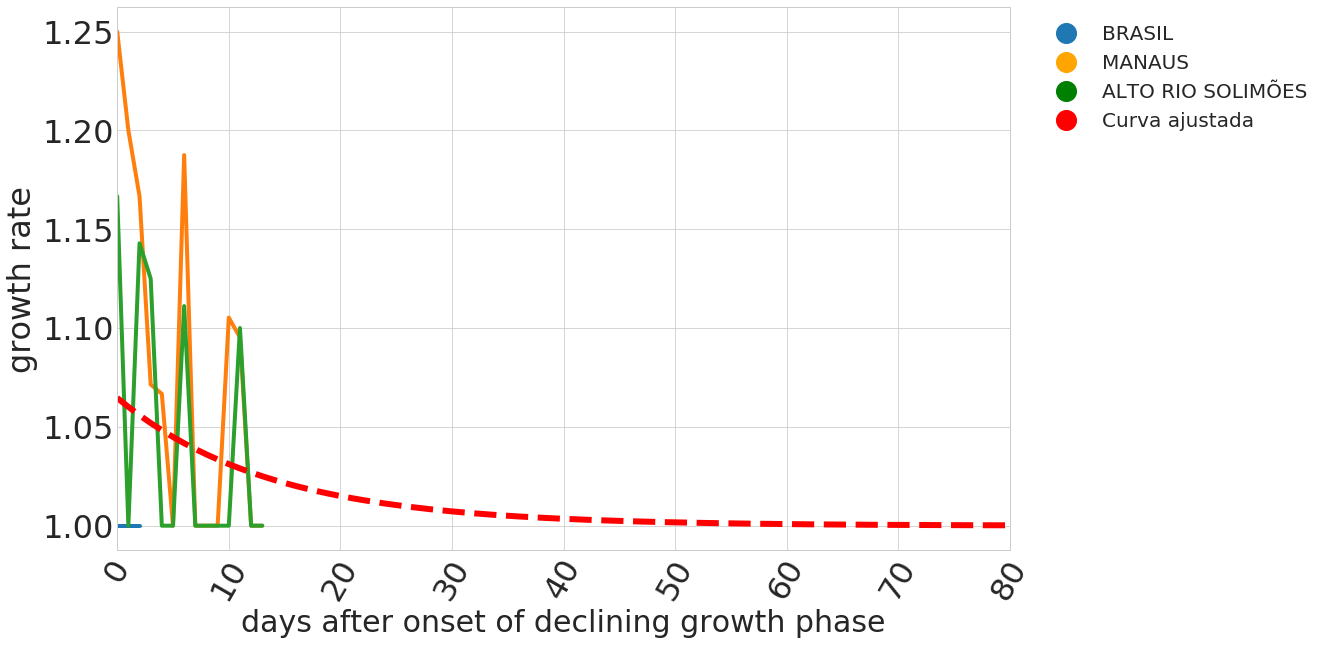

In [21]:
# Changed by Silvio: use Sesai districts (DSEIs)
#country1 = "Italy"
#country2 = "China"
#country3 = "Iran"
#country4 = "Spain"
country1 = "BRASIL"
country2 = "MANAUS"
country3 = "ALTO RIO NEGRO"
country4 = "ALTO RIO SOLIMÕES"

gr1 = list(calculateGR(country1, 23))
gr2 = list(calculateGR(country2, 23))
gr3 = list(calculateGR(country3, 23))
gr4 = list(calculateGR(country4, 23))

# Changed by Silvio: do not slide
#g1 = gr1[19:len(gr1)]
#g2 = gr2[10:len(gr2)]
#g3 = gr3[14:len(gr3)]
#g4 = gr4[14:len(gr4)]
g1 = gr1
g2 = gr2
g3 = gr3
g4 = gr4

plt.figure(figsize=(16,10))
plt.plot(g2, label="Death rate ("+country2+")", linewidth=4)
plt.plot(g1, label="Death rate ("+country1+")", linewidth=4)
#plt.plot(g3, label="Death rate ("+country3+")", linewidth=4)
plt.plot(g4, label="Death rate ("+country4+")", linewidth=4)

plt.xticks(rotation=60, fontsize=32)
plt.yticks(fontsize=32)

def func(x, a, b):
    return a * np.exp(-b * x)+1

#x = list(range(0,len(g1)))+list(range(0, len(g2)))
#y = list(g1+g2)
x = list(range(0,len(g1)))+list(range(0, len(g2)))+list(range(0, len(g4)))
y = list(g1+g2+g4)

# Changed by Silvio: debug
#print(gr1)
#print(gr2)
#print(gr4)
#print(x)
#print(y)

popt, params_covariance = optimize.curve_fit(func, x[3:len(x)], y[3:len(y)], p0=[2, 2])

xrange = 200
fit_rate = func(np.array(list(range(0, xrange))), *popt)

print(popt)

plt.plot(np.array(list(range(0,xrange))), fit_rate, 'r--', label="Fitted Curve", linewidth=6)

plt.ylabel("growth rate", fontsize=32)
plt.xlabel("days after onset of declining growth phase", fontsize=30)
plt.xlim(0,80)

legend_elements = [Line2D([0], [0], marker='o', linewidth=0, label=country1, markersize=20),
                   Line2D([0], [0], marker='o', linewidth=0, color="orange", label=country2, markersize=20),
                   Line2D([0], [0], marker='o', linewidth=0, color="g", label=country4, markersize=20),
                   Line2D([0], [0], marker='o', linewidth=0, color="r", label='Curva ajustada', markersize=20)]
                   
plt.legend(handles=legend_elements, fontsize=20, bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1)

In [22]:
def findDecayShift(growthrates, decay_spline):
    decay_shift = 0
    ff = fitLinear(growthrates[-5:])
    ff = statistics.median(growthrates[-5:])
    
    while float(ff) < float(list(decay_spline)[decay_shift]):
        decay_shift = decay_shift +1
        if decay_shift-1 > len(decay_spline):
            break
    return(decay_shift+3)

In [23]:
def extrapolateDeaths(country, fitrate, intervention, timescale=60, shift=0, pastDays=23, exprate=1.25):
    
    ma = np.where(cases["Country/Region"] == country)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c1 = d_count_1 / c_count_1
    d_cases = np.where(d_count_1 > 10)[0]
    sds2 = d_count_1[d_cases]
    
    gr = calculateGR(country, 23)
    gr = gr[0:(len(gr)-shift)]
    
    predicted_deaths = list(range(0,timescale))
    predicted_deaths[0] = sds2[-(1+shift)]
    
    #ff = fitUp(sds2[0:(1+shift)], len(sds2)+40)
    j = 0
    for i in range(1,timescale):
        if i < 23-pastDays:
            predicted_deaths[i] = predicted_deaths[i-1]*exprate
            #predicted_deaths[i] = predicted_deaths[i-1]*statistics.median(gr[-4:])
            #predicted_deaths[i] = ff[(shift)+i]
        else:
            predicted_deaths[i] = predicted_deaths[i-1]*fitrate[j-intervention]
            j = j+1
    
    dd =sds2.index
    datelist = pd.date_range(pd.to_datetime(dd[len(dd)-1], format='%m/%d/%y', errors='ignore'), periods=timescale).tolist()
    str_date = [d.strftime('%m/%d/%y') for d in datelist]
    
    return(pd.DataFrame(data=predicted_deaths, index=str_date))

4/25/20    1.250000
4/24/20    1.200000
4/23/20    1.166667
4/22/20    1.071429
4/21/20    1.066667
4/20/20    1.000000
4/19/20    1.187500
4/18/20    1.000000
4/17/20    1.000000
4/16/20    1.000000
4/15/20    1.105263
4/14/20    1.095238
4/13/20    1.000000
4/12/20    1.000000
dtype: float64
[1.06465634 1.0601036  1.05587144 1.05193728 1.04828015 1.04488053
 1.04172029 1.03878258 1.03605173 1.03351316 1.03115335 1.02895971
 1.02692053 1.02502493 1.02326282 1.02162478 1.02010208 1.0186866
 1.0173708  1.01614764 1.01501062 1.01395365 1.01297111 1.01205776
 1.01120872 1.01041946 1.00968578 1.00900376 1.00836977 1.00778042
 1.00723256 1.00672329 1.00624987 1.00580979 1.00540069 1.00502041
 1.0046669  1.00433828 1.0040328  1.00374884 1.00348486 1.00323948
 1.00301137 1.00279933 1.00260222 1.00241898 1.00224865 1.00209031
 1.00194313 1.0018063  1.00167911 1.00156088 1.00145097 1.0013488
 1.00125383 1.00116554 1.00108347 1.00100718 1.00093626 1.00087033
 1.00080905 1.00075208 1.00069912 1.0

IndexError: list index out of range

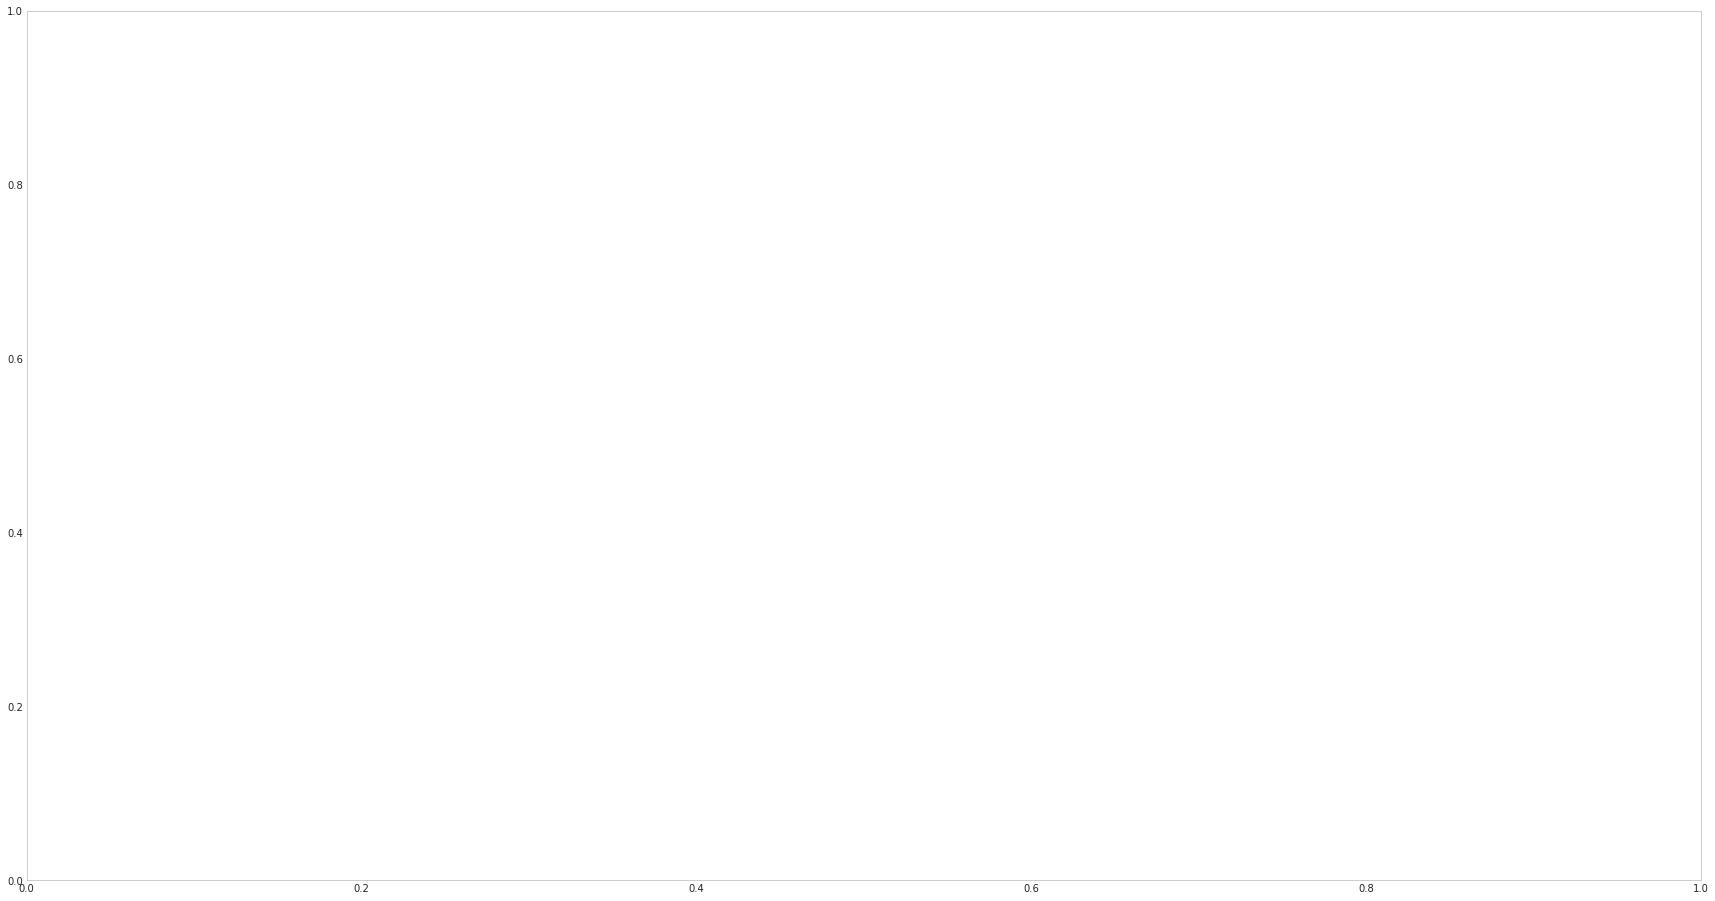

In [29]:
# Changed by Silvio: adjust country
#country = "US"
country = "BRASIL"
limi = 18

ma = np.where(cases["Country/Region"] == country)[0]
c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
dr_c1 = d_count_1 / c_count_1
d_cases = np.where(d_count_1 > 10)[0]
sds2 = d_count_1[d_cases]

ggr = calculateGR(country, 0)

plt.figure(figsize=(30,16))
ax1 = plt.subplot(1,1,1)

ax1.grid(False)
#plt.ylim(top=(list(exp_d.iloc[:,0])[-1]+500))

mink = 0
minsd = 100000000

for k in range(18, 46):
    expl = list()
    for i in range(0,limi):
        sts = statistics.mean(ggr[0:(len(ggr)-i)][-5:])
        decay_position = -findDecayShift(ggr[0:(len(ggr)-i)], fit_rate)    
        exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80+i, shift=i, pastDays=k-i)
        expl.append(exp_d.iloc[-1,0])
    print("K: "+str(k)+ " SD: "+str(statistics.stdev(expl)))
    if statistics.stdev(expl) < minsd:
        minsd = statistics.stdev(expl)
        mink = k

minr = 1.2
minsd = 1000000000
for k in [1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3]:
    expl = list()
    for i in range(1,limi):
        decay_position = -findDecayShift(ggr[0:(len(ggr)-i)], fit_rate)    
        exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80+i, shift=i, pastDays=mink-i, exprate=k)
        expl.append(exp_d.iloc[-1,0])
    print("r: "+str(k)+ " SD: "+str(statistics.stdev(expl)))
    if statistics.stdev(expl) < minsd:
        minsd = statistics.stdev(expl)
        minr = k        

for i in range(1,limi):
    decay_position = -findDecayShift(ggr[0:(len(ggr)-i)], fit_rate)
    exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80+i, shift=i, pastDays=mink-i, exprate=minr)
    ax1.plot(range(len(sds2)-i, len(sds2)-i+len(exp_d)-1), exp_d[1:len(exp_d)], 'r--', label="Predicted Deaths", linewidth=4, color="black", alpha=(limi-i)/(limi+20))

decay_position = -findDecayShift(ggr, fit_rate)
exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80, pastDays=mink)

res1, = ax1.plot(sds2, linewidth=14, label="Reported Deaths")
res3, = ax1.plot(exp_d[1:len(exp_d)], 'r--', label="Predicted Deaths", linewidth=14)

l1 = np.array(([0]+list(exp_d))) - np.array((list(exp_d)+[0]))

plt.xticks(rotation=60, fontsize=40)
plt.yticks(fontsize=50)

s1 = list(exp_d.iloc[:,0])+[0]
s2 = [0]+list(exp_d.iloc[:,0])

ax2 = ax1.twinx()
plt.yticks(fontsize=50)
dd = (np.array(s1)-np.array(s2))[1:(len(s1)-1)]
res4, = ax2.plot(range(len(sds2)-10,(len(dd)-10+len(sds2))),dd/np.max(np.array(dd)), 'g--', linewidth=14, label="Hospitalizations / max Hospitalizations")

for label in ax1.xaxis.get_ticklabels()[::1]:
    label.set_visible(False)

for label in ax1.xaxis.get_ticklabels()[::8]:
    label.set_visible(True)

plt.title(country, fontsize=60)
ax1.set_ylabel('cases', color="black", fontsize=50)
color = 'green'
ax2.set_ylabel('expected hospitalizations / max expected hospitalizations', color=color, fontsize=40)
ax2.tick_params(axis='y', labelcolor=color)

legend_elements = [Line2D([0], [0], marker='o', linewidth=0, label='Reported Deaths', markersize=30),
                   Line2D([0], [0], marker='o', linewidth=0, color="r", label='Predicted Deaths', markersize=30),
                   Line2D([0], [0], marker='o', linewidth=0, color="g", label='Predicted Hospitalizations', markersize=30)]
                   
plt.legend(handles=legend_elements, fancybox = True, fontsize=40, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)

1/22/20        0
1/23/20        0
1/24/20        0
1/25/20        0
1/26/20        0
1/27/20        0
1/28/20        0
1/29/20        0
1/30/20        0
1/31/20        0
2/1/20         0
2/2/20         0
2/3/20         0
2/4/20         0
2/5/20         0
2/6/20         0
2/7/20         0
2/8/20         0
2/9/20         0
2/10/20        0
2/11/20        0
2/12/20        0
2/13/20        0
2/14/20        0
2/15/20        0
2/16/20        0
2/17/20        0
2/18/20        0
2/19/20        0
2/20/20        0
           ...  
4/18/20    20043
4/19/20    20453
4/20/20    20852
4/21/20    21282
4/22/20    21717
4/23/20    22157
4/24/20    22524
4/25/20    22902
4/26/20    23190
4/27/20    23521
4/28/20    23822
4/29/20    24275
4/30/20    24543
5/1/20     24543
5/2/20     25100
5/3/20     25264
5/4/20     25428
5/5/20     25613
5/6/20     25857
5/7/20     26070
5/8/20     26299
5/9/20     26478
5/10/20    26621
5/11/20    26744
5/12/20    26920
5/13/20    27104
5/14/20    27321
5/15/20    274

<Figure size 720x432 with 0 Axes>

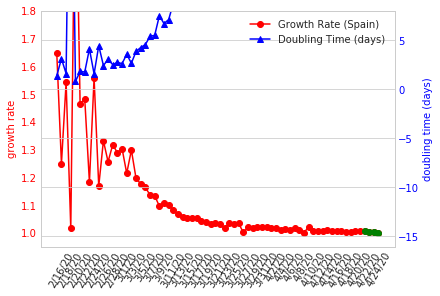

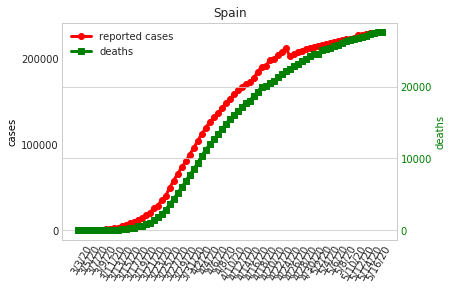

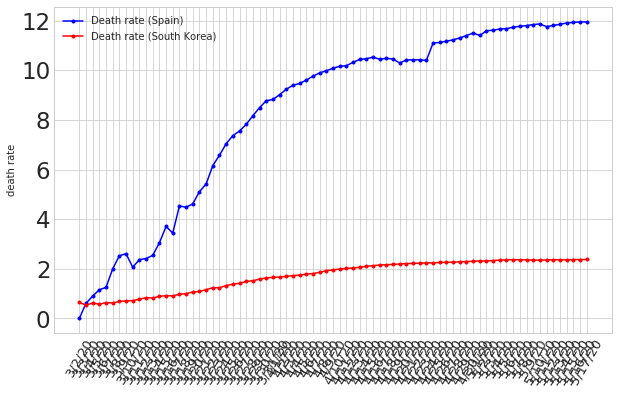

In [21]:
country1 = "Spain"
country2 = "South Korea"

ma = np.where(cases["Country/Region"] == country1)[0]
c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
print(d_count_1)
print(c_count_1[-6:])

ggr = calculateGR(country1, 0)

print("Current Confirmed Cases:", c_count_1[-1])
print("Current Confirmed Deaths:", d_count_1[-1])

ma = np.where(cases["Country/Region"] == country2)[0]
c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)

drr = d_count_1[-1]/c_count_1[-1]

mean_days_death = 18
asym_days = 5

d_shift = mean_days_death + asym_days

exp_diff = calcVF(country1, country2)
print("Vunerablility Factor: ", str(round(exp_diff, 4)))

exp_d = extrapolateDeaths(country1, fit_rate, -findDecayShift(ggr, fit_rate), timescale=80)

print("Total Deaths: ", str(int(exp_d.iloc[-1,0])))

num = exp_d.iloc[d_shift]/(exp_diff*drr)
print("Current Predicted Cases: ", str(int(num)))

num = exp_d.iloc[-1]/(exp_diff*drr)
print("Total Predicted Cases: ", str(int(num)))

gr = calculateGR(country1, d_shift)
print("Growth Rate: ", str(round(gr[-1], 5)))

mean_gr = sum(list(gr))/len(list(gr))
mean_double = math.log(2)/math.log(mean_gr)
doublings = np.log(2)/np.log(gr)
print("Days per Doubling: ", str(round(doublings[-1], 5)))

#print("Total Predicted Cases: ",shift_cases[-1])

plotGR(country1, gr, doublings)
plotDR(country1, country2)

In [22]:
def plotPred(country, ax1):
    limi = 18
    ma = np.where(cases["Country/Region"] == country)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c1 = d_count_1 / c_count_1
    d_cases = np.where(d_count_1 > 10)[0]
    sds2 = d_count_1[d_cases]

    ggr = calculateGR(country, 0)
    
    ax1.grid(False)
    
    mink = 0
    minsd = 100000000

    for k in range(18, 80):
        expl = list()
        for i in range(0,limi):
            sts = statistics.mean(ggr[0:(len(ggr)-i)][-5:])
            decay_position = -findDecayShift(ggr[0:(len(ggr)-i)], fit_rate)    
            exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80+i, shift=i, pastDays=k-i)
            expl.append(exp_d.iloc[-1,0])
        #print("K: "+str(k)+ " SD: "+str(statistics.stdev(expl)))
        if statistics.stdev(expl) < minsd:
            minsd = statistics.stdev(expl)
            mink = k

    minr = 1.2
    minsd = 1000000000
    for k in [1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3]:
        expl = list()
        for i in range(1,limi):
            decay_position = -findDecayShift(ggr[0:(len(ggr)-i)], fit_rate)    
            exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80+i, shift=i, pastDays=mink-i, exprate=k)
            expl.append(exp_d.iloc[-1,0])
        #print("r: "+str(k)+ " SD: "+str(statistics.stdev(expl)))
        if statistics.stdev(expl) < minsd:
            minsd = statistics.stdev(expl)
            minr = k        

            
    print("K: "+str(mink)+" R: "+str(minr))
    
    for i in range(0,limi):
        decay_position = -findDecayShift(ggr[0:(len(ggr)-i)], fit_rate)
        exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80+i, shift=i, pastDays=mink-i, exprate=minr)
        ax1.plot(range(len(sds2)-i, len(sds2)-i+len(exp_d)-1), exp_d[1:len(exp_d)], 'r--', label="Predicted Deaths", linewidth=4, color="black", alpha=(limi-i)/(limi+20))

    decay_position = -findDecayShift(ggr, fit_rate)
    print(decay_position)
    exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80)

    res1, = ax1.plot(sds2, linewidth=14, label="Reported Deaths")
    res3, = ax1.plot(exp_d[1:len(exp_d)], 'r--', label="Predicted Deaths", linewidth=14)
    
    l1 = np.array(([0]+list(exp_d))) - np.array((list(exp_d)+[0]))

    plt.xticks(rotation=60, fontsize=40)
    plt.yticks(fontsize=50)

    s1 = list(exp_d.iloc[:,0])+[0]
    s2 = [0]+list(exp_d.iloc[:,0])

    ax2 = ax1.twinx()
    plt.yticks(fontsize=50)
    dd = (np.array(s1)-np.array(s2))[1:(len(s1)-1)]
    res4, = ax2.plot(range(len(sds2)-10,(len(dd)-10+len(sds2))),dd/np.max(np.array(dd)), 'g--', linewidth=14, label="Hospitalizations / max Hospitalizations")

    for label in ax1.xaxis.get_ticklabels()[::1]:
        label.set_visible(False)

    for label in ax1.xaxis.get_ticklabels()[::8]:
        label.set_visible(True)

    plt.title(country, fontsize=80)
    ax1.set_ylabel('deaths', color="black", fontsize=50)
    color = 'green'
    ax2.set_ylabel('expected hosp / max expected hosp', color=color, fontsize=40)
    ax2.tick_params(axis='y', labelcolor=color)


K: 39 R: 1.15
-46
K: 39 R: 1.15
-48
K: 38 R: 1.15
-30
K: 39 R: 1.15
-43
K: 39 R: 1.15
-34
K: 39 R: 1.15
-43
K: 39 R: 1.15
-41


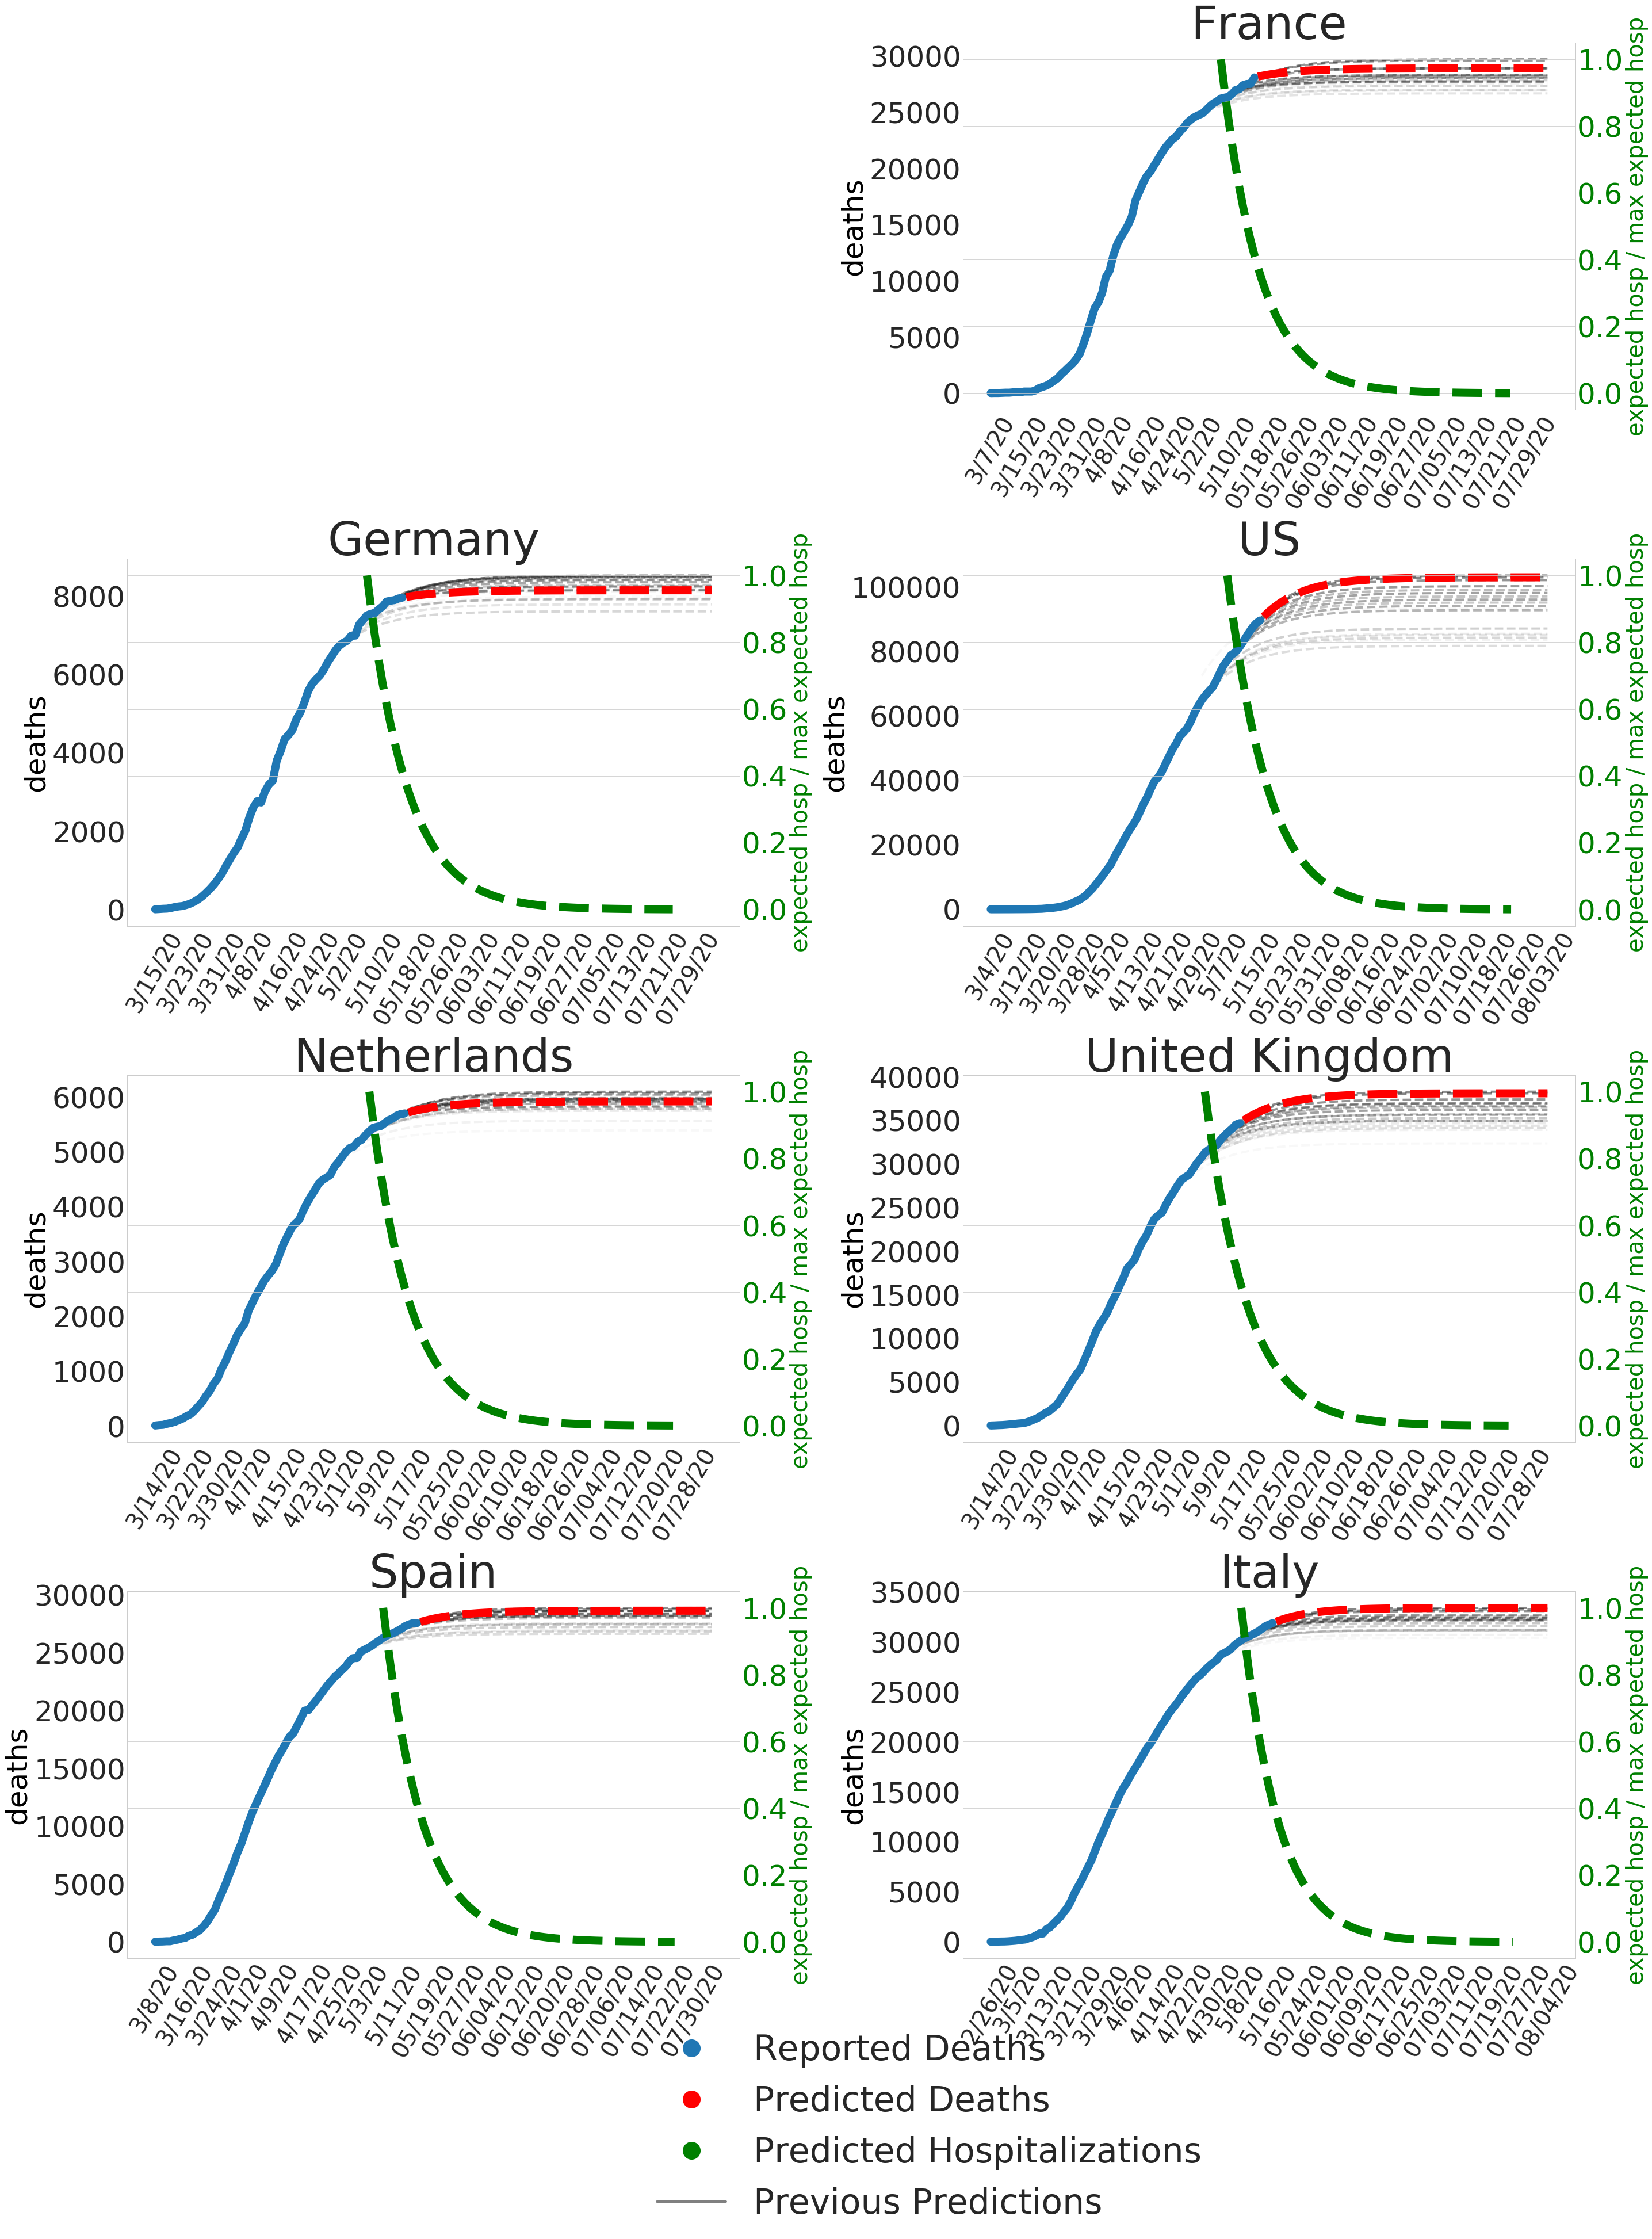

In [23]:
plt.figure(figsize=(40,50))

# Changes by Silvio: giving IndexError
#ax1 = plt.subplot(4,2,1)
#plotPred("China", ax1)

ax1 = plt.subplot(4,2,2)
plotPred("France", ax1)

ax1 = plt.subplot(4,2,3)
plotPred("Germany", ax1)

ax1 = plt.subplot(4,2,4)
plotPred("US", ax1)

ax1 = plt.subplot(4,2,5)
plotPred("Netherlands", ax1)

ax1 = plt.subplot(4,2,6)
plotPred("United Kingdom", ax1)

ax1 = plt.subplot(4,2,7)
plotPred("Spain", ax1)

ax1 = plt.subplot(4,2,8)
plotPred("Italy", ax1)

plt.tight_layout(w_pad=1.5)

legend_elements = [Line2D([0], [0], marker='o', linewidth=0, label='Reported Deaths', markersize=30),
                   Line2D([0], [0], marker='o', linewidth=0, color="r", label='Predicted Deaths', markersize=30),
                   Line2D([0], [0], marker='o', linewidth=0, color="g", label='Predicted Hospitalizations', markersize=30),
                   Line2D([0], [0], linewidth=4, color="grey", label='Previous Predictions')]

plt.legend(handles=legend_elements, fancybox = True, fontsize=60, bbox_to_anchor=(-0.55, -0.8), loc='lower left', ncol=1)


In [24]:
for country in ["United Kingdom","Netherlands","Spain","Germany","US","China","France","Italy"]:
    printStat(country)

United Kingdom
Current Confirmed Cases: 244995
Current Confirmed Deaths: 34716
5/12/20    227741
5/13/20    230985
5/14/20    234440
5/15/20    238004
5/16/20    241461
5/17/20    244995
dtype: int64
Current Confirmed Cases: 244995
Current Confirmed Deaths: 34716
Vunerablility Factor:  1.238
Total Deaths:  38123
Current Predicted Cases:  1283396
Total Predicted Cases:  1295597
Growth Rate:  1.00492
Days per Doubling:  141.20195
------------------------------------
Netherlands
Current Confirmed Cases: 44195
Current Confirmed Deaths: 5699
5/12/20    43183
5/13/20    43410
5/14/20    43680
5/15/20    43880
5/16/20    44070
5/17/20    44195
dtype: int64
Current Confirmed Cases: 44195
Current Confirmed Deaths: 5699
Vunerablility Factor:  1.2503
Total Deaths:  5921
Current Predicted Cases:  198484
Total Predicted Cases:  199252
Growth Rate:  1.00176
Days per Doubling:  394.6779
------------------------------------
Spain
Current Confirmed Cases: 230698
Current Confirmed Deaths: 27563
5/12/20 

IndexError: list index out of range

In [ ]:
def plotCaseCountry(country, ax1):
    ma = np.where(cases['Country/Region'] == country)[0]
    c_count = cases.iloc[ma, 4:].sum(axis=0)
    d_count = deaths.iloc[ma, 4:].sum(axis=0)
    
    sig_cases = np.where(c_count > 300)[0]
    
    res1, = plt.plot(c_count[sig_cases], 'ro-', linewidth=14, label="reported cases")
    plt.xticks(rotation=60, fontsize=32)
    plt.yticks(fontsize=32)
    
    ax2 = ax1.twinx()
    res3, = ax2.plot(d_count[sig_cases], 'gs-', linewidth=14, label="deaths")

    for label in ax1.xaxis.get_ticklabels()[::1]:
        label.set_visible(False)

    for label in ax1.xaxis.get_ticklabels()[::6]:
        label.set_visible(True)

    plt.yticks(fontsize=32)
    plt.title(country, fontsize=60)
    ax1.set_ylabel('confirmed cases', color="black", fontsize=45)
    color = 'green'
    ax2.set_ylabel('deaths', color=color, fontsize=45)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.legend(handles=[res1, res3], fontsize=40)


In [ ]:
plt.figure(figsize=(40,20))

ax1 = plt.subplot(2,3,1)
plotCaseCountry("China", ax1)

ax1 = plt.subplot(2,3,2)
plotCaseCountry("US", ax1)

ax1 = plt.subplot(2,3,3)
plotCaseCountry("Italy", ax1)

ax1 = plt.subplot(2,3,4)
plotCaseCountry("Germany", ax1)

ax1 = plt.subplot(2,3,5)
plotCaseCountry("United Kingdom", ax1)

ax1 = plt.subplot(2,3,6)
plotCaseCountry("Spain", ax1)

plt.tight_layout(w_pad=1.5)
